In [51]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import expit as sigmoid  
from scipy.optimize import linprog
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns

In [52]:
root_path = '/Users/francescoiaccarino/Desktop/tesi/final_dataset_2'
train_path = root_path + '/training_v2.csv'
test_path = root_path + '/unlabeled.csv'
explanation_path = root_path + '/WiDS Datathon 2020 Dictionary.csv'

In [53]:
train = pd.read_csv(train_path, index_col = [0])
test = pd.read_csv(test_path, index_col = [0])

In [54]:
explanation = pd.read_csv(explanation_path)

### Data Cleaning 

In [55]:
len(train.columns[10:])

175

In [56]:
# Drop the 'hospital_id' as it's not needed for the analysis

def drop_cols(df, feature):
    if type(feature) == list:
        for _ in feature:
            df.drop(_, axis = 1, inplace = True)
    if type(feature) == str:
        df.drop(feature, axis = 1, inplace = True)
    
    return None

In [57]:
drop_cols(train, "hospital_id")
drop_cols(test, "hospital_id")

In [58]:
# We design a table with the percentage of missing values in the dataframe 

def missing_data_table(df):
    
    count = df.isnull().sum().sort_values(ascending = True)
    percentage = df.isnull().mean().sort_values(ascending = True)
    
    missing_data = pd.concat([count, percentage], axis = 1, keys = ['count', 'percentage'])
    
    return missing_data

missing_train = missing_data_table(train)
missing_test = missing_data_table(test)

In [59]:
missing_train.percentage[109:]

wbc_apache            0.240010
urineoutput_apache    0.534254
d1_albumin_min        0.535322
d1_albumin_max        0.535322
h1_glucose_max        0.573681
                        ...   
h1_albumin_min        0.913982
h1_lactate_min        0.919924
h1_lactate_max        0.919924
h1_bilirubin_max      0.922650
h1_bilirubin_min      0.922650
Name: percentage, Length: 75, dtype: float64

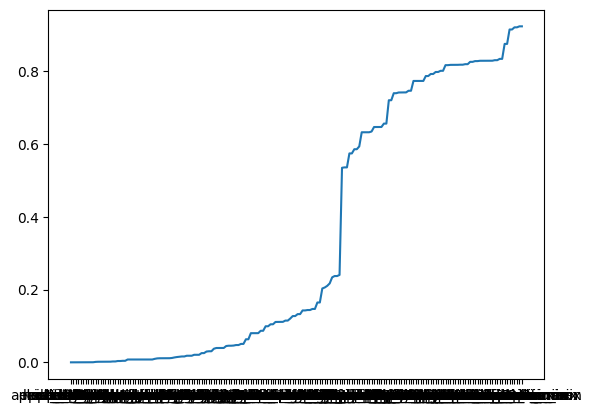

In [60]:
plt.plot(missing_train.percentage)

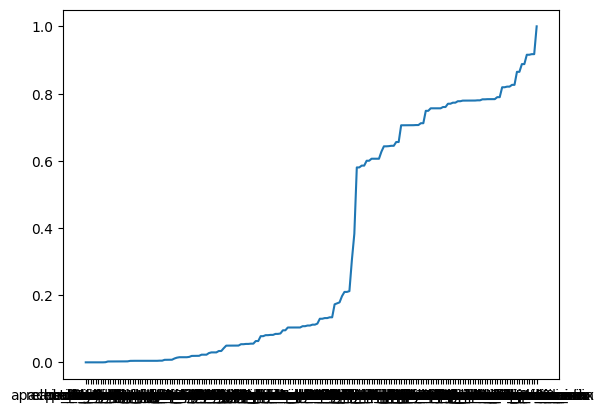

In [61]:
plt.plot(missing_test.percentage)

In [62]:
# Drop the insignificant features as they have too much missing values

def drop_missing_values(df, missing_data):
    
    #df.drop(missing_data[(missing_data['percentage'] > 0.3) & (missing_data['percentage'] < 0.99)].index, axis=1, inplace=True)
    df.drop(missing_data[missing_data['percentage'] > 0.3].index, axis = 1, inplace = True)
    
    return None

a, x = train.shape, test.shape

drop_missing_values(train, missing_train)
drop_missing_values(test, missing_test)

b, y = train.shape, test.shape

print(f"{a[1] - b[1]} features have been canceled from train")
print(f"{x[1] - y[1]} features have been canceled from test")

74 features have been canceled from train
76 features have been canceled from test


we are deleting also the variable 'hospital_death', we have to add it again

In [63]:
a = ['d1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_mbp_invasive_max', 'd1_mbp_invasive_min', 'd1_sysbp_invasive_max', 'd1_sysbp_invasive_min', 'h1_diasbp_invasive_max', 'h1_diasbp_invasive_min', 'h1_mbp_invasive_max', 'h1_mbp_invasive_min', 'h1_sysbp_invasive_max', 'h1_sysbp_invasive_min']
for i in a:
    if i in list(missing_train[missing_train['percentage'] > 0.3].index):
        print("True")
    else:
        print("False")

True
True
True
True
True
True
True
True
True
True
True
True


### Null imputing 

In [64]:
def find_categorical(data):
    
    cols = data.columns
    num_cols = data._get_numeric_data().columns
    categorical = list(set(cols) - set(num_cols))
    
    return categorical

In [65]:
def imputer(df):
    
    categorical_cols = find_categorical(df)
    numerical_cols = list(set(df.columns) - set(categorical_cols))
    
    cat_imputer = SimpleImputer(strategy='most_frequent')
    num_imputer = SimpleImputer(strategy='mean')

    df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])
    df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])
    
    return None

In [66]:
imputer(train)

In [67]:
imputer(test)

### Normalization

In [68]:
# Normalization for test data set 
def scaler(df):
    
    scaler = MinMaxScaler()
    scaler.fit(df[df._get_numeric_data().columns])
    scaler.transform(df[df._get_numeric_data().columns])
    
    return None

In [69]:
scaler(train)

In [70]:
scaler(test)

### Grouping of the lots of variables

In [71]:
coefficients = {
    'age': 0.03,  # Nonlinear increase with age
    'd1_heartrate_min': -0.2, 'd1_heartrate_max': 0.2,
    'h1_heartrate_min': -0.3, 'h1_heartrate_max': 0.3,
    'd1_sysbp_max': 0.1, 'd1_sysbp_min': -0.1,
    'h1_sysbp_min': -0.2, 'h1_sysbp_max': 0.2,
    'd1_diasbp_min': -0.05, 'd1_diasbp_max': 0.05,
    'h1_diasbp_min': -0.1, 'h1_diasbp_max': 0.1,
    'd1_spo2_min': 0.7, 'd1_spo2_max': -0.1,  # Increased importance for oxygen saturation
    'd1_resprate_max': 0.5, 'd1_resprate_min': -0.5,
    'h1_resprate_max': 0.6, 'h1_resprate_min': -0.6,  # Increased importance for respiratory rate
    'd1_temp_min': -0.1, 'd1_temp_max': 0.1,
    'h1_temp_min': -0.2, 'h1_temp_max': 0.2,
    'd1_glucose_max': 0.2, 'd1_glucose_min': -0.2
}


In [72]:
def calculate_probability_to_get_sick(df, coefficients):
    # Filter to only use columns that exist in both the DataFrame and the coefficients dictionary
    valid_columns = [col for col in df.columns if col in coefficients]
    
    # Check if all intended columns are being processed
    #print("Valid columns :", valid_columns)
    
    df_work = df[valid_columns].copy()
    
    # Apply median imputation
    imputer = SimpleImputer(strategy='median')
    df_work = imputer.fit_transform(df_work)
    
    # Standardize the data
    scaler = StandardScaler()
    df_work = scaler.fit_transform(df_work)
    
    # Convert array back to DataFrame to facilitate operations
    df_work = pd.DataFrame(df_work, columns=valid_columns)
    
    # Calculate the weighted sum using a more robust method to prevent any alignment issues
    weights = np.array([coefficients[col] for col in valid_columns])
    df['weighted_sum'] = np.dot(df_work, weights)
    
    # Apply sigmoid function to scale results between 0 and 100
    df['probability_to_get_sick'] = sigmoid(df['weighted_sum']) * 100
    
    return df

In [73]:
# Assuming the DataFrame and coefficients are defined correctly
train = calculate_probability_to_get_sick(train, coefficients)
print(train[['probability_to_get_sick']].head())

              probability_to_get_sick
encounter_id                         
66154                       62.716217
114252                      22.128749
119783                      53.603919
79267                       73.063849
92056                       34.702315


/var/folders/67/vb8vkx4x68db4hstv4v2_1lh0000gn/T/ipykernel_14481/4080473166.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['weighted_sum'] = np.dot(df_work, weights)
/var/folders/67/vb8vkx4x68db4hstv4v2_1lh0000gn/T/ipykernel_14481/4080473166.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['probability_to_get_sick'] = sigmoid(df['weighted_sum']) * 100


In [74]:
test = calculate_probability_to_get_sick(test, coefficients)
print(test[['probability_to_get_sick']].head())

              probability_to_get_sick
encounter_id                         
2                           62.014777
5                           29.843104
7                           65.462093
8                           44.586701
10                          77.676415


/var/folders/67/vb8vkx4x68db4hstv4v2_1lh0000gn/T/ipykernel_14481/4080473166.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['weighted_sum'] = np.dot(df_work, weights)
/var/folders/67/vb8vkx4x68db4hstv4v2_1lh0000gn/T/ipykernel_14481/4080473166.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['probability_to_get_sick'] = sigmoid(df['weighted_sum']) * 100


In [75]:
train.to_csv('train1.csv', index=False)

Now drop all those columns, but before we should implement also a PCA, dimensionality reduction

In [76]:
cols = []
for i in list(missing_train[missing_train['percentage'] < 0.3].index):
    if i[:2] == "d1" or i[:2] == "h1":
        cols.append(i)

In [77]:
drop_cols(train, cols)

In [78]:
drop_cols(test, cols)

### CHECK APACHE 

I want to understand which of the features contains effectively the apache score which is 
The acute physiology and chronic health evaluation (APACHE) II severity score has shown a good calibration 
and discriminatory value across a range of disease processes and remains the most widely used 
source of prognostic information on the risk for death in patients admitted to intensive care units (ICUs).

In [79]:
word = 'apache'
boo2 = []
for i in list(explanation['Variable Name']):
    if word in i:
        boo2.append(True)
    else:
        boo2.append(False)

In [80]:
a = explanation[boo2]

### SIMULATION OF ILLNESS

In [81]:
def simulate_illness(df, num_patients=1000, probability_col='probability_to_get_sick'):
    # Make sure probabilities sum to 1 for proper random selection
    df[probability_col + '_scaled'] = df[probability_col] / df[probability_col].sum()
    
    # I am selecting 1000 individuals based on the scaled probability
    sick_individuals = df.sample(n=num_patients, weights=probability_col + '_scaled', replace=False)
    
    # I am creating a column for sick individuals initialized with False
    df['sick_individuals'] = False
    
    # Mark the selected sick individuals as True
    df.loc[sick_individuals.index, 'sick_individuals'] = True
    
    return df  


In [82]:
train = simulate_illness(train)

In [83]:
test = simulate_illness(test)

In [84]:
train.sick_individuals.sum()

1000

In [85]:
def assign_priority(df, age_weight, apache_score_weight, apache_prob_weight):
    # Normalizing weights
    total_weight = age_weight + apache_score_weight + apache_prob_weight
    age_weight /= total_weight
    apache_score_weight /= total_weight
    apache_prob_weight /= total_weight

    # I'm calculating priority score based on weighted criteria
    df['priority_score'] = (df['age'] * age_weight + 
                            df['apache_4a_icu_death_prob'] * apache_score_weight +
                            df['apache_4a_hospital_death_prob'] * apache_prob_weight)
    
    # I'm defining thresholds for priority levels (these need to be defined based on data distribution)
    thresholds = df['priority_score'].quantile([0.25, 0.50, 0.75])
    
    # I'm assigning priority levels
    df['priority'] = pd.cut(df['priority_score'], bins=[-np.inf, thresholds[0.25], thresholds[0.50], thresholds[0.75], np.inf], 
                            labels=['White', 'Green', 'Yellow', 'Red'])
    
    return df

In [86]:
train = assign_priority(train, 4, 2, 2) 
test = assign_priority(test, 4, 2, 2)

In [87]:
from scipy.optimize import linprog

def optimize_bed_allocation_scipy(df, n_beds=320):
    # Initialize the objective function array with death probabilities
    c = -df['apache_4a_hospital_death_prob'].values
    
    # Setup for applying penalties to guide the bed allocation towards desired proportions
    target_proportions = {'Red': 0.40, 'Yellow': 0.30, 'Green': 0.20, 'White': 0.10}
    penalty_weights = 0.1  # Adjust this factor to balance between death minimization and proportion target
    
    # Apply penalties directly within the DataFrame structure for each priority group
    for priority, target in target_proportions.items():
        is_priority = df['priority'] == priority
        # Calculate penalty factor for not meeting target proportion
        penalty_factor = (target - (is_priority.mean() / target)) * penalty_weights
        # Apply penalties
        c[is_priority] += penalty_factor
    
    # Define bounds for each variable, allowing only sick individuals to be assigned beds
    x_bounds = [(0, 1) if sick else (0, 0) for sick in df['sick_individuals']]

    # Constraint to keep total beds within the available number
    A = [[1] * len(df)]
    b = [n_beds]

    # Solve the linear programming problem
    result = linprog(c, A_ub=A, b_ub=b, bounds=x_bounds, method='highs')
    df['bed_assigned'] = result.x >= 0.5  # Assign beds based on the LP solution

    return df

In [88]:
train = optimize_bed_allocation_scipy(train)
train[['priority', 'apache_4a_hospital_death_prob', 'bed_assigned']].head()

,priority,apache_4a_hospital_death_prob,bed_assigned
encounter_id,,,
66154,Yellow,0.100000,False
114252,Red,0.470000,False
119783,White,0.000000,False
79267,Red,0.040000,False
92056,White,0.086787,False


In [89]:
test = optimize_bed_allocation_scipy(test)

In [91]:
optimization_results = test['bed_assigned']

In [92]:
def run_iterations(df, iterations=50, num_patients=1000, n_beds=320):
    results = []
    bed_allocation_per_priority = []
    for _ in range(iterations):
        # Simulate illness in the dataset
        simulated_df = simulate_illness(df.copy(), num_patients=num_patients)
        
        # Assign priority based on the current state
        priority_df = assign_priority(simulated_df, 4, 2, 2)
        
        # Optimize bed allocation
        optimized_df = optimize_bed_allocation_scipy(priority_df, n_beds)
        
        # Collect total beds assigned
        beds_assigned_count = optimized_df['bed_assigned'].sum()
        results.append(beds_assigned_count)
        
        # Collect bed assignment per priority group
        beds_by_priority = optimized_df[optimized_df['bed_assigned']].groupby('priority').size()
        bed_allocation_per_priority.append(beds_by_priority)
        
    return results, pd.DataFrame(bed_allocation_per_priority).fillna(0)


In [93]:
def visualize_bed_allocation_by_priority(beds_per_priority):
    colors = ['red', 'yellow', 'green', 'gray']  # Specify colors
    beds_per_priority.plot(kind='bar', stacked=True, color=colors, figsize=(12, 6))
    plt.title('Bed Allocation by Priority Group Across Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Number of Beds Assigned')
    plt.legend(title='Priority', labels=['Red', 'Yellow', 'Green', 'White'])
    plt.show()



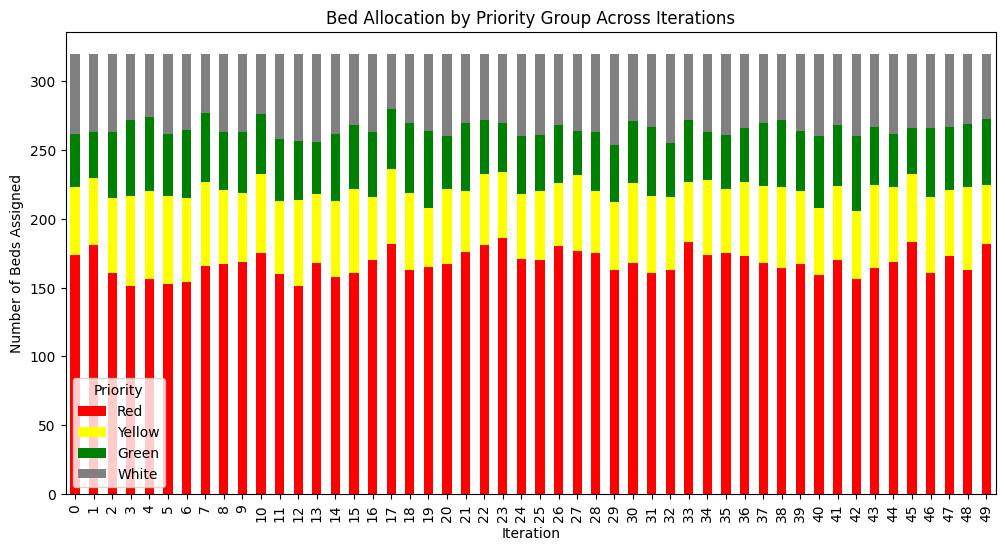

In [94]:
total_beds_assigned, beds_per_priority = run_iterations(train, iterations=50, num_patients=1000, n_beds=320)
visualize_bed_allocation_by_priority(beds_per_priority)

In [95]:
train.to_csv('train1.csv', index=False)

In [96]:
test.to_csv('test1.csv', index=False)

In [97]:
print(set(train.columns) - set(test.columns))

{'hospital_admit_source', 'hospital_death'}


In [98]:
drop_cols(train, "hospital_admit_source")
drop_cols(train, "hospital_death")

### Machine learning models to predict bed assignment

In [99]:
# Identifying categorical columns
categorical_cols = find_categorical(train)

# Preparing the training data
features_train = train.drop('bed_assigned', axis=1)
target_train = train['bed_assigned']

In [100]:
# This is the full pipeline: OneHotEncoder for categorical, StandardScaler for numerical, and PCA
column_transformer = ColumnTransformer([
    ('cat', OneHotEncoder(), categorical_cols),
    ('num', StandardScaler(), list(set(features_train.columns) - set(categorical_cols)))
])

In [101]:
# Full pipeline with PCA and RandomForest
pipeline = Pipeline([
    ('preprocessor', column_transformer),
    ('pca', PCA(n_components=0.95)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

In [102]:
# Fit the pipeline on the training data
pipeline.fit(features_train, target_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['apache_3j_bodysystem',
                                                   'apache_2_bodysystem',
                                                   'icu_admit_source',
                                                   'ethnicity', 'icu_type',
                                                   'priority', 'icu_stay_type',
                                                   'gender']),
                                                 ('num', StandardScaler(),
                                                  ['bmi',
                                                   'apache_4a_icu_death_prob',
                                                   'gcs_unable_apache',
                                                   'patient_id',
                                                   'gcs_eyes_apache',
                                                   'lymphoma', 'priority_score',...
                                                   'apache_post_operative',
                                                   'intubated_apache',
                                                   'arf_apache', 'aids',
                                                   'probability_to_get_sick_scaled',
                                                   'solid_tumor_with_metastasis',
                                                   'age',
                                                   'probability_to_get_sick',
                                                   'immunosuppression',
                                                   'gcs_motor_apache',
                                                   'wbc_apache', 'cirrhosis',
                                                   'height',
                                                   'hematocrit_apache',
                                                   'diabetes_mellitus', ...])])),
                ('pca', PCA(n_components=0.95)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [112]:
# Predict on the test data
test_predictions = pipeline.predict(test)

In [113]:
test['bed_assigned'] = test_predictions

In [114]:
rnd_forest_test_predictions = test.bed_assigned

In [49]:
print(test.head()) 

              patient_id        age        bmi  elective_surgery   
encounter_id                                                       
2               127112.0  56.000000  21.102439               0.0  \
5               130737.0  61.313991  19.500595               1.0   
7               101458.0  66.000000  32.518596               1.0   
8                48067.0  64.000000  20.798520               0.0   
10               25865.0  56.000000  28.947566               0.0   

                     ethnicity gender      height           icu_admit_source   
encounter_id                                                                   
2                    Caucasian      M  180.300000       Accident & Emergency  \
5                    Caucasian      F  145.000000  Operating Room / Recovery   
7             African American      M  170.200000  Operating Room / Recovery   
8                    Caucasian      M  182.800000  Operating Room / Recovery   
10                   Caucasian      M  169.

In [115]:
rnd_forest_test_predictions.isna().sum()

0

In [117]:
from sklearn.metrics import accuracy_score

# Relevant columns
# optimization_results -> results of the optimization algorithm
# test_predictions     -> results of the random forest run

# Compare the results
accuracy = accuracy_score(optimization_results, rnd_forest_test_predictions)
print(f"Accuracy of Random Forest predictions compared to optimization results: {accuracy}")

Accuracy of Random Forest predictions compared to optimization results: 0.9945812557240257


In [50]:
test.to_csv('test_with_predictions.csv', index=False) 